<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/experimental/ML_model(Resampling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd


In [ ]:
nifty = yf.download('^nsei',start='2014-01-01',end='2020-12-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
nifty.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-29,13910.349609,13967.599609,13859.900391,13932.599609,13932.599609,439600
2020-12-30,13980.900391,13997.000000,13864.950195,13981.950195,13981.950195,380700


In [ ]:
nifty['close_2%']=np.abs(nifty['Adj Close'].pct_change()*100)

In [ ]:
nifty['var']=nifty['close_2%'].cumsum()

In [ ]:
nifty['cumsum']=np.where(nifty['var']<0.02,nifty['var'],nifty['close_2%'])

In [ ]:
nifty[nifty['cumsum']>0.02]

,Open,High,Low,Close,Adj Close,Volume,close_2%,var,cumsum
Date,,,,,,,,,
2014-01-03,6194.549805,6221.700195,6171.250000,6211.149902,6211.149902,139000,0.160742,0.160742,0.160742
2014-01-06,6220.850098,6224.700195,6170.250000,6191.450195,6191.450195,118300,0.317167,0.477909,0.317167
2014-01-07,6203.899902,6221.500000,6144.750000,6162.250000,6162.250000,138600,0.471621,0.949530,0.471621
2014-01-08,6178.049805,6192.100098,6160.350098,6174.600098,6174.600098,146900,0.200415,1.149945,0.200415
2014-01-09,6181.700195,6188.049805,6148.250000,6168.350098,6168.350098,150100,0.101221,1.251167,0.101221
...,...,...,...,...,...,...,...,...,...
2020-12-23,13473.500000,13619.450195,13432.200195,13601.099609,13601.099609,458700,1.001016,1232.276825,1.001016
2020-12-24,13672.150391,13771.750000,13626.900391,13749.250000,13749.250000,471400,1.089253,1233.366078,1.089253
2020-12-28,13815.150391,13885.299805,13811.549805,13873.200195,13873.200195,403600,0.901505,1234.267583,0.901505


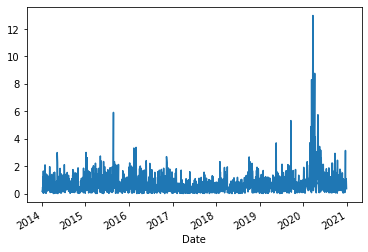

In [ ]:
nifty['cumsum'].plot()

In [ ]:
#nifty['cumm_change']=np.where(nifty['close_2%'].cumsum()<2.50,nifty['close_2%'].cumsum(),nifty['close_2%']) & np.where(nifty['close_2%'].cumsum()>2.50,)

In [ ]:
#nifty['assigned_group']=np.where(nifty['cumsum'].diff()<2,nifty['cumsum'],nifty['close_2%'])

In [ ]:
nifty.head(20)

,Open,High,Low,Close,Adj Close,Volume,close_2%,var,cumsum
Date,,,,,,,,,
2014-01-02,6301.250000,6358.299805,6211.299805,6221.149902,6221.149902,158100,NaN,NaN,NaN
2014-01-03,6194.549805,6221.700195,6171.250000,6211.149902,6211.149902,139000,0.160742,0.160742,0.160742
2014-01-06,6220.850098,6224.700195,6170.250000,6191.450195,6191.450195,118300,0.317167,0.477909,0.317167
2014-01-07,6203.899902,6221.500000,6144.750000,6162.250000,6162.250000,138600,0.471621,0.949530,0.471621
2014-01-08,6178.049805,6192.100098,6160.350098,6174.600098,6174.600098,146900,0.200415,1.149945,0.200415
2014-01-09,6181.700195,6188.049805,6148.250000,6168.350098,6168.350098,150100,0.101221,1.251167,0.101221
2014-01-10,6178.850098,6239.100098,6139.600098,6171.450195,6171.450195,159900,0.050258,1.301425,0.050258
2014-01-13,6189.549805,6288.200195,6189.549805,6272.750000,6272.750000,135000,1.641426,2.942851,1.641426
2014-01-14,6260.250000,6280.350098,6234.149902,6241.850098,6241.850098,110200,0.492605,3.435456,0.492605


In [ ]:
nifty['class']=0

count=1
for i in range(len(nifty)):
 
  #print('count : ',count)
    if ((nifty['cumsum'].iloc[i]<nifty['cumsum'].iloc[i-1]) & (nifty['cumsum'].iloc[i]==nifty['close_2%'].iloc[i])):
      nifty['class'].iloc[i]=count
    
  


In [152]:
nifty

,Open,High,Low,Close,Adj Close,Volume,close_2%,var,cumsum,class
Date,,,,,,,,,,
2014-01-02,6301.250000,6358.299805,6211.299805,6221.149902,6221.149902,158100,NaN,NaN,NaN,0
2014-01-03,6194.549805,6221.700195,6171.250000,6211.149902,6211.149902,139000,0.160742,0.160742,0.160742,0
2014-01-06,6220.850098,6224.700195,6170.250000,6191.450195,6191.450195,118300,0.317167,0.477909,0.317167,0
2014-01-07,6203.899902,6221.500000,6144.750000,6162.250000,6162.250000,138600,0.471621,0.949530,0.471621,0
2014-01-08,6178.049805,6192.100098,6160.350098,6174.600098,6174.600098,146900,0.200415,1.149945,0.200415,1
...,...,...,...,...,...,...,...,...,...,...
2020-12-23,13473.500000,13619.450195,13432.200195,13601.099609,13601.099609,458700,1.001016,1232.276825,1.001016,1
2020-12-24,13672.150391,13771.750000,13626.900391,13749.250000,13749.250000,471400,1.089253,1233.366078,1.089253,0
2020-12-28,13815.150391,13885.299805,13811.549805,13873.200195,13873.200195,403600,0.901505,1234.267583,0.901505,1


In [153]:
nifty['class'].value_counts(normalize=True)


0    0.503214
1    0.496786
Name: class, dtype: float64